In [14]:
import mlflow
import pandas as pd
import mlflow.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/monalbhuva/Dataset/refs/heads/main/Reddit_Data.csv')
df.head()


,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


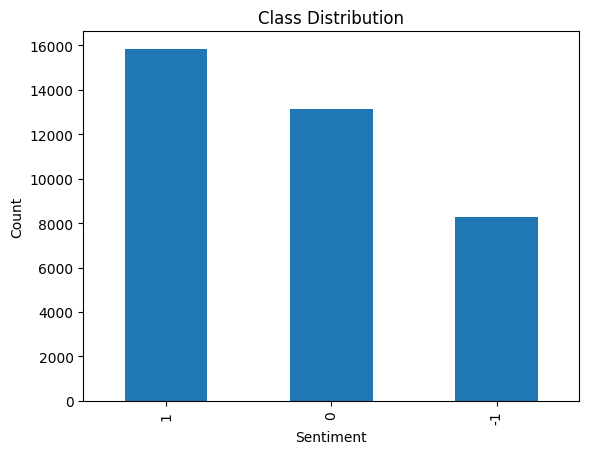

In [16]:
import matplotlib.pyplot as plt

df['category'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [17]:
df['category'].value_counts()

category
 1    15830
 0    13142
-1     8277
Name: count, dtype: int64

In [18]:
import pandas as pd
from sklearn.utils import resample

# Separate classes
df_class_1 = df[df['category'] == 1]
df_class_0 = df[df['category'] == 0]
df_class_neg1 = df[df['category'] == -1]

# Set target size (e.g., average of all classes)
target_size = int((len(df_class_1) + len(df_class_0) + len(df_class_neg1)) / 3)
print("Target size per class:", target_size)

# Undersample majority class
df_class_1_sampled = resample(df_class_1,
                              replace=False,
                              n_samples=target_size,
                              random_state=42)

# Oversample minority classes
df_class_0_sampled = resample(df_class_0,
                              replace=True,
                              n_samples=target_size,
                              random_state=42)

df_class_neg1_sampled = resample(df_class_neg1,
                                 replace=True,
                                 n_samples=target_size,
                                 random_state=42)

# Combine all
df_balanced = pd.concat([df_class_1_sampled, df_class_0_sampled, df_class_neg1_sampled])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check distribution
print(df_balanced['category'].value_counts())
print("Total rows after hybrid balancing:", len(df_balanced))


Target size per class: 12416
category
 1    12416
 0    12416
-1    12416
Name: count, dtype: int64
Total rows after hybrid balancing: 37248


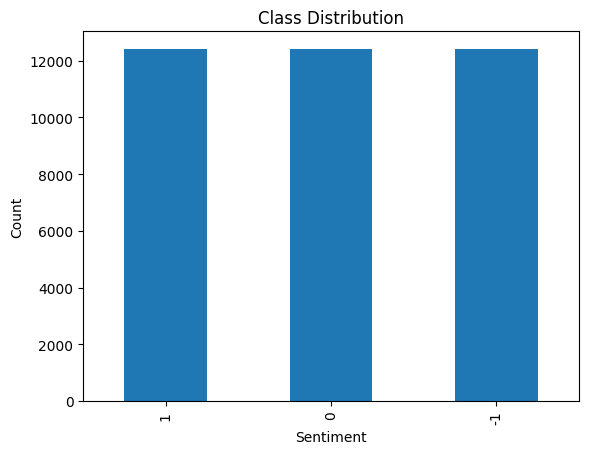

In [19]:
df_balanced['category'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [20]:
df = df_balanced.copy()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37248 entries, 0 to 37247
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37161 non-null  object
 1   category       37248 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [23]:
# Define the preprocessing function
def preprocess_comment(comment):
    """Apply preprocessing transformations to a comment."""
    try:
        # Convert to lowercase
        comment = comment.lower()

        # Remove trailing and leading whitespaces
        comment = comment.strip()

        # Remove newline characters
        comment = re.sub(r'\n', ' ', comment)

        # Remove non-alphanumeric characters, except punctuation
        comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

        # Remove stopwords but retain important ones for sentiment analysis
        stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
        comment = ' '.join([word for word in comment.split() if word not in stop_words])

        # Lemmatize the words
        lemmatizer = WordNetLemmatizer()
        comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

        return comment
    except Exception as e:
        print(f"Error in preprocessing comment: {e}")
        return comment
    

def normalize_text(df):
    """Apply preprocessing to the text data in the dataframe."""
    try:
        df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)
        print('Text normalization completed')
        return df
    except Exception as e:
        print(f"Error during text normalization: {e}")
        raise

In [24]:
df['clean_comment'] = df['clean_comment'].astype(str)  # ensure all strings
df = normalize_text(df)
df.head()

Text normalization completed


,clean_comment,category
0,marking unverified till provide source thanks,1
1,store buy missionary charity speak south india...,0
2,kill,0
3,thanks pre ordered book amazon day became avai...,1
4,thing boring news interested ate chole bhature...,-1


In [25]:
vectorizer = CountVectorizer(max_features=50)
X = vectorizer.fit_transform(df['clean_comment'])
y = df['category']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
import dagshub

mlflow.set_tracking_uri('https://dagshub.com/monalAJ/YT-Personal-Project.mlflow')
dagshub.init(repo_owner='monalAJ', repo_name='YT-Personal-Project', mlflow=True)

# mlflow.set_experiment("Logistic Regression Baseline")
mlflow.set_experiment("Logistic Regression Baseline")

Accessing as monalAJ

Initialized MLflow to track repo "monalAJ/YT-Personal-Project"

Repository monalAJ/YT-Personal-Project initialized!

2025/10/04 10:32:28 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/353e6ee78c574cfdb28cbe555d06386e', creation_time=1759554139120, experiment_id='0', last_update_time=1759554139120, lifecycle_stage='active', name='Logistic Regression Baseline', tags={}>

In [ ]:
import mlflow
import logging
import os
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

logging.info("Starting MLflow run...")

with mlflow.start_run():
    start_time = time.time()
    
    try:
        logging.info("Logging preprocessing parameters...")
        mlflow.log_param("vectorizer", "Bag of Words")
        mlflow.log_param("num_features", 100)
        mlflow.log_param("test_size", 0.25)

        logging.info("Initializing Logistic Regression model...")
        model = LogisticRegression(max_iter=1000)  # Increase max_iter to prevent non-convergence issues

        logging.info("Fitting the model...")
        model.fit(X_train, y_train)
        logging.info("Model training complete.")

        logging.info("Logging model parameters...")
        mlflow.log_param("model", "Logistic Regression")

        logging.info("Making predictions...")
        y_pred = model.predict(X_test)

        logging.info("Calculating evaluation metrics...")
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="weighted")


        logging.info("Logging evaluation metrics...")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        logging.info("Saving and logging the model...")
        mlflow.sklearn.log_model(model, "model")

        # Log execution time
        end_time = time.time()
        logging.info(f"Model training and logging completed in {end_time - start_time:.2f} seconds.")

        # Save and log the notebook
        # notebook_path = "exp1_baseline_model.ipynb"
        # logging.info("Executing Jupyter Notebook. This may take a while...")
        # os.system(f"jupyter nbconvert --to notebook --execute --inplace {notebook_path}")
        # mlflow.log_artifact(notebook_path)

        # logging.info("Notebook execution and logging complete.")

        # Print the results for verification
        logging.info(f"Accuracy: {accuracy}")
        logging.info(f"Precision: {precision}")
        logging.info(f"Recall: {recall}")
        logging.info(f"F1 Score: {f1}")

    except Exception as e:
        logging.error(f"An error occurred: {e}", exc_info=True)


2025-10-04 10:39:20,774 - INFO - Starting MLflow run...
2025-10-04 10:39:21,228 - INFO - Logging preprocessing parameters...
2025-10-04 10:39:22,458 - INFO - Initializing Logistic Regression model...
2025-10-04 10:39:22,461 - INFO - Fitting the model...
2025-10-04 10:39:22,696 - INFO - Model training complete.
2025-10-04 10:39:22,698 - INFO - Logging model parameters...
2025-10-04 10:39:23,055 - INFO - Making predictions...
2025-10-04 10:39:23,061 - INFO - Calculating evaluation metrics...
2025-10-04 10:39:23,078 - INFO - Logging evaluation metrics...
2025-10-04 10:39:24,811 - INFO - Saving and logging the model...
2025/10/04 10:39:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-10-04 10:39:51,239 - INFO - Model training and logging completed in 30.01 seconds.
2025-10-04 10:39:51,242 - INFO - Accuracy: 0.5175042955326461
2025-10-04 10:39:51,244 - INFO 

🏃 View run delicate-cod-879 at: https://dagshub.com/monalAJ/YT-Personal-Project.mlflow/#/experiments/0/runs/91ef35e1a0774f78af21aa97d26c31b5
🧪 View experiment at: https://dagshub.com/monalAJ/YT-Personal-Project.mlflow/#/experiments/0
